# Positional Encoding

The self attention mechanism operates on a set of tokens and are naturally permutation invariant. Using a motivating example of the phrase, "the dog chased another dog". Here dog are 2 entirely different entities in the sentence with the same spelling.

In [11]:
import torch
import torch.nn as nn
import tiktoken

text = "The dog chased another dog"
tokenizer = tiktoken.get_encoding("gpt2")
encodedText = torch.tensor(tokenizer.encode(text))
print(f"{text} -> {encodedText}")

embedDims = 128
wEmbed = nn.Embedding(tokenizer.max_token_value, embedDims)
embeddedText = wEmbed(encodedText)
print(f"{text} -> Embedded tensor of shape {embeddedText.shape}")

The dog chased another dog -> tensor([  464,  3290, 26172,  1194,  3290])
The dog chased another dog -> Embedded tensor of shape torch.Size([5, 128])


In [29]:
wQ = nn.Linear(embedDims, embedDims, bias=False)
wK = nn.Linear(embedDims, embedDims, bias=False)
wV = nn.Linear(embedDims, embedDims, bias=False)

mha = nn.MultiheadAttention(embed_dim=embedDims, num_heads=4, batch_first=False)
with torch.no_grad():
    for param in mha.parameters():
        nn.init.normal_(param, std=0.1)

torch.Size([5, 128])
torch.Size([5, 5])


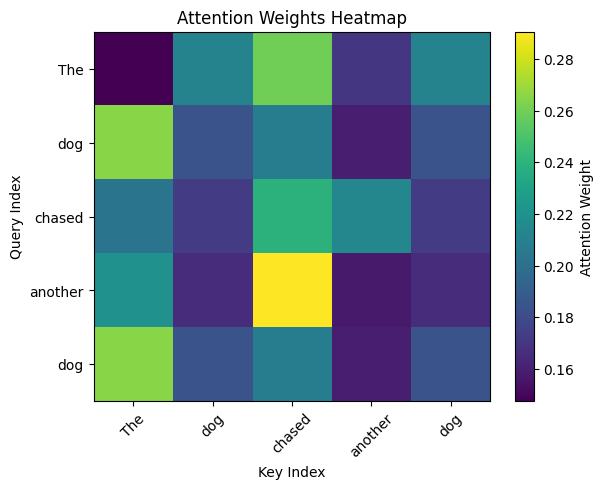

In [38]:
with torch.no_grad():
    attnOutput, attnWeights = mha(wQ(embeddedText), wK(embeddedText), wV(embeddedText))
print(attnOutput.shape)
print(attnWeights.shape)

import matplotlib.pyplot as plt

plt.imshow(attnWeights.detach().numpy(), cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.xlabel('Key Index')
plt.ylabel('Query Index')
plt.title('Attention Weights Heatmap')
plt.xticks(ticks=range(len(text.split())), labels=text.split(), rotation=45)
plt.yticks(ticks=range(len(text.split())), labels=text.split())
plt.show()

As you can see from the above attention heatmap, the columns 1 and 4 for "dog" are both the same because the term "dog" taken as a single out of context word has the same embedding and dot products regardless of where or when the operation was performed.

In [43]:
dog1 = attnOutput[1, :]
dog2 = attnOutput[4, :]
print(f"Attention outputs for both 'dog' entries are close: {torch.allclose(dog1, dog2, atol=1e-6)}")

dog1 = attnWeights[1, :]
dog2 = attnWeights[4, :]
print(f"Attention weights for both 'dog' entries are close: {torch.allclose(dog1, dog2, atol=1e-6)}")

Attention outputs for both 'dog' entries are close: True
Attention weights for both 'dog' entries are close: True


From an english speaker's perspective, "dog" in that sentence are completely different but from a maths perspective, they're are the same.
We need a way to encode the concept of a word having a different meaning depending on it's position in a sequence and this is exactly what **positional encoding** does!.

Positional encoding ensures that the term "dog" in the phrase "dog barks in the night, another dog hears the call, dogs in harmony." would take on an entirely different embedding so that they are treated differently during self attention, just like human languages would associate context to each "dog" occurrence.

## Desirable properties for a positional encoding scheme

1. Unique encoding for each position: A token should have a unique encoding regardless of the sequence length.
2. Linear relation between two encoded positions: It should be easy for the model to learn how a given position $p$, relates to a later position $p+k$. A simple scheme would the number line where it is obvious that 2 positions after 3 ($p$) should be the position 5 ($p+k$).
3. It should be independent of the sequence length: This invariance to the sequence length is required so that the scheme can handle lengths outside what it was trained on.
4. The positioning scheme should be deterministic and learnable: related to #2. The model should be able learn how these encoding label position over any sequence length.
5. Support tokens in arbitrary dimensions i.e 1D sequences, 2D sequences or nD sequences: This is aimed at multi-modal models like Vision LLMs that can handle text and images sequences.

## Some position encoding schemes
### Integer position encoding
